In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

%matplotlib inline

In [2]:
train = pd.read_csv('../../data/feedback-prize-2021/train.csv')

train.shape

(144293, 8)

In [3]:
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [4]:
train.iloc[2]['discourse_text']

'Some certain areas in the United States ban phones from class rooms just because of it. '

In [5]:
train.isnull().sum()

id                    0
discourse_id          0
discourse_start       0
discourse_end         0
discourse_text        0
discourse_type        0
discourse_type_num    0
predictionstring      0
dtype: int64

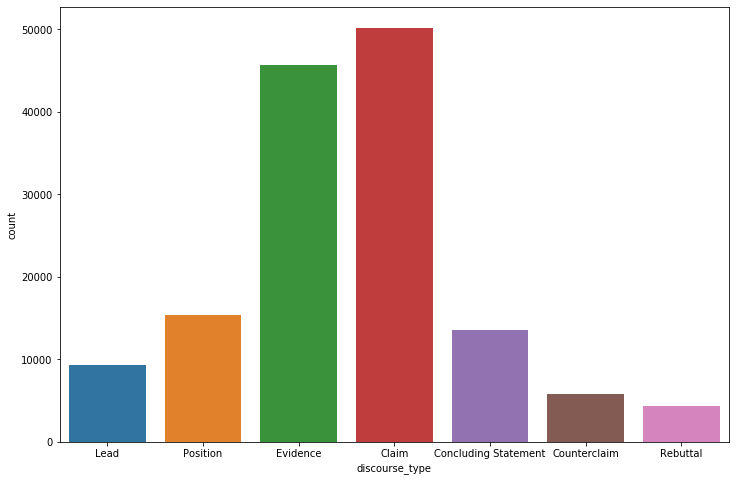

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x='discourse_type', data=train)

## Preprocessing

In [7]:
def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    text = str(text).lower().split()
    
    if remove_stopwords:
        stops = stopwords.words("english")
        text = [x for x in text if not x in stops]
        
    text = ' '.join(text)
    
    text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
    text = re.sub(r"\]", " ", text)
    text = re.sub(r"\[", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\\", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"0x00", "", text)
    
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stem_words = [stemmer.stem(x) for x in text]
        text = " ".join(text)
        
    if lemma:
        text = text.split()
        lem = WordNetLemmatizer()
        lemmatized = [lem.lemmatize(x, "v") for x in text]
        text = " ".join(text)
        
    return text

In [8]:
%%time
train['cleaned_text'] = train.discourse_text.apply(clean_text)

CPU times: user 44.8 s, sys: 3.93 s, total: 48.7 s
Wall time: 48.7 s


In [9]:
train.iloc[0]['discourse_text']

'Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.'

In [10]:
train.iloc[0]['cleaned_text']

'modern humans today always phone always phone 5 hours day stop all text back forward group chats social media even driving'

## Count Vectorizer

In [11]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(train['cleaned_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [12]:
train_count =  count_vect.transform(train['cleaned_text'])
count_vect.get_feature_names()

['00',
 '00 00',
 '00 22',
 '00 30',
 '00 57',
 '00 70',
 '00 accidents',
 '00 allowed',
 '00 along',
 '00 also',
 '00 am',
 '00 average',
 '00 biggest',
 '00 bus',
 '00 catch',
 '00 choice',
 '00 citation',
 '00 common',
 '00 dollar',
 '00 each',
 '00 evening',
 '00 every',
 '00 exhausting',
 '00 expecting',
 '00 finishes',
 '00 four',
 '00 gallon',
 '00 gas',
 '00 get',
 '00 gets',
 '00 giving',
 '00 goes',
 '00 homework',
 '00 injuries',
 '00 many',
 '00 midnight',
 '00 mini',
 '00 month',
 '00 months',
 '00 morning',
 '00 next',
 '00 night',
 '00 now',
 '00 ol',
 '00 order',
 '00 people',
 '00 per',
 '00 pets',
 '00 pick',
 '00 pm',
 '00 pocket',
 '00 point',
 '00 points',
 '00 punishment',
 '00 ready',
 '00 rides',
 '00 second',
 '00 students',
 '00 take',
 '00 there',
 '00 therefore',
 '00 till',
 '00 time',
 '00 tired',
 '00 voters',
 '00 wake',
 '00 weeks',
 '00 would',
 '00 year',
 '000',
 '000 000',
 '000 001',
 '000 2017',
 '000 35',
 '000 455',
 '000 70',
 '000 90',
 '000 a

In [27]:
len(count_vect.get_feature_names())

1015340

In [30]:
train_count_df = pd.DataFrame(train_count.todense(), columns=count_vect.get_feature_names())
train_count_df.head()

,00,00 00,00 22,00 30,00 57,00 70,00 accidents,00 allowed,00 along,00 also,...,zygomstic,zygomstic major,zygomtic,zygomtic major,zygosmtic,zygosmtic major,årgument,årgument really,ëvening,ëvening star
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(train_count_df, train['discourse_type'])
scores = []

In [ ]:
 a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
X, y = make_classification(n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

## ML Models


For multi class classification problem try:
    - SVM Classifier
    - Random Forest classifier
    - Naive Balyes

In [37]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)


### Random Forest Classifier

In [38]:
rf_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

In [ ]:
scores = cross_val_score(rf_model, train_count_df, train['discourse_type'], scoring='accuracy', cv=cv)

In [ ]:
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [2]:
train_count_df.shape

NameError: name 'train_count_df' is not defined